In [6]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from dbn import SupervisedDBNRegression
np.random.seed(2018)

In [2]:
dataset = pd.read_csv("data/idraud.csv")

In [3]:
df = dataset["IDR/AUD"].values
df = df.astype('float32')
df = df.reshape(-1,1)

len_train = int(len(df)*0.70)
len_val = int(len(df)*0.10)

train = df[0:len_train]
validation = df[len_train:len_train+len_val]
test = df[len_train+len_val:]

scaler = MinMaxScaler(feature_range=(0, 1)).fit(train)
train = scaler.transform(train)
validation = scaler.transform(validation)
test = scaler.transform(test)


# create time series from dataset
def create_sliding_windows(data, lag=1):
    X = []
    y = []
    for i in range(len(data)-lag-1):
        cek = data[i:(i+lag),0]
        X.append(cek)
        y.append(data[i+lag,0])
    return np.array(X), np.array(y)


lag = 3
X_train, y_train = create_sliding_windows(train, lag)
y_train = np.reshape(y_train, (len(y_train), 1))
X_val, y_val = create_sliding_windows(validation, lag)
X_test, y_test = create_sliding_windows(test, lag)


In [4]:
X_train[0]

array([0.81492186, 0.8707032 , 0.8682809 ], dtype=float32)

In [10]:
# Training
regressor = SupervisedDBNRegression(hidden_layers_structure=[30, 40],
                                    optimization_algorithm='sgd',
                                    learning_rate_rbm=0.001,
                                    learning_rate=0.001,
                                    n_epochs_rbm=30,
                                    n_iter_backprop=100,
                                    batch_size=32,
                                    activation_function='relu',
                                    dropout_p=0.2,
                                    train_optimization_algorithm='sgd')
regressor.fit_and_validate(X_train, y_train, X_val, y_val)

# Save the model
regressor.save('model.pkl')

# prediction
y_pred = regressor.predict(X_test)

[START] Pre-training step:
>> Epoch 1 finished 	RBM Reconstruction error 0.399733
>> Epoch 2 finished 	RBM Reconstruction error 0.387303
>> Epoch 3 finished 	RBM Reconstruction error 0.375303
>> Epoch 4 finished 	RBM Reconstruction error 0.363734
>> Epoch 5 finished 	RBM Reconstruction error 0.352454
>> Epoch 6 finished 	RBM Reconstruction error 0.341538
>> Epoch 7 finished 	RBM Reconstruction error 0.331075
>> Epoch 8 finished 	RBM Reconstruction error 0.320914
>> Epoch 9 finished 	RBM Reconstruction error 0.310977
>> Epoch 10 finished 	RBM Reconstruction error 0.301488
>> Epoch 11 finished 	RBM Reconstruction error 0.292312
>> Epoch 12 finished 	RBM Reconstruction error 0.283423
>> Epoch 13 finished 	RBM Reconstruction error 0.274745
>> Epoch 14 finished 	RBM Reconstruction error 0.266413
>> Epoch 15 finished 	RBM Reconstruction error 0.258465
>> Epoch 16 finished 	RBM Reconstruction error 0.250727
>> Epoch 17 finished 	RBM Reconstruction error 0.243442
>> Epoch 18 finished 	RBM Reco

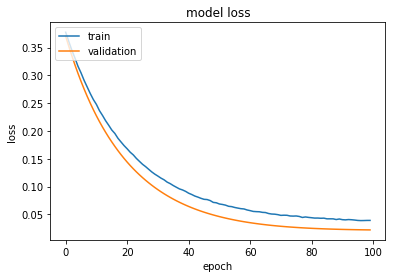

In [11]:
plt.plot(regressor.train_loss)
plt.plot(regressor.validation_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()